In [1]:
from diffusers import EulerAncestralDiscreteScheduler, DDIMScheduler, UNet2DModel, DDPMScheduler

In [2]:
from matfusion_jax.vis import display_image, display_svbrdf, show_svbrdf

In [3]:
import imageio.v3 as iio
import cv2
import numpy as np
import torch
from pathlib import Path
import tqdm

# Model Loading

In [4]:
device = 'cuda'

In [5]:
model = UNet2DModel.from_pretrained('./checkpoints/env_v1_diffusers/').to(device)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


# Input Loading

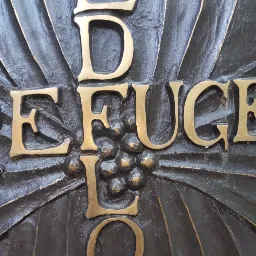

In [6]:
# TODO: pick your own image
# make sure it is linear RGB with a 2.2 gamma (roughly sRGB without tonemapping)
image = iio.imread('./demo/wildflower_sign_input.png')
image = cv2.resize(image, (256, 256))
image = np.expand_dims(image, 0)
image = (image / 255.0) ** 2.2
display_image(image, gamma=2.2)

In [7]:
replicates = 10

model_input = torch.tensor(image, device=device, dtype=torch.float32).permute(0, 3, 1, 2) * 2 - 1
model_input = model_input.repeat((replicates, 1, 1, 1))

# Run MatFusion using Huggingface Diffusers

In [8]:
euler_a_schedule = EulerAncestralDiscreteScheduler(
    beta_schedule='linear',
    prediction_type='v_prediction',
    timestep_spacing="linspace",
)
schedule = euler_a_schedule
schedule.set_timesteps(20)
timestep_mult = model.config.get('timestep_mult', 1/1000)

In [9]:
with torch.no_grad():
    y = torch.randn(replicates, 10, *model_input.shape[2:], device=device, dtype=torch.float32)
    y = y * schedule.init_noise_sigma

    for t in tqdm.tqdm(schedule.timesteps):
        noisy_svbrdf = schedule.scale_model_input(y, t)
        model_output = model(
            torch.cat((noisy_svbrdf, model_input), 1),
            t*timestep_mult,
        ).sample

        step_output = schedule.step(model_output, t, y)
        y = step_output.prev_sample

        svbrdf_est = (step_output.pred_original_sample * 0.5 + 0.5).clamp(0, 1).permute(0, 2, 3, 1).cpu().numpy()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.72it/s]


# Pick your favorite replicate!

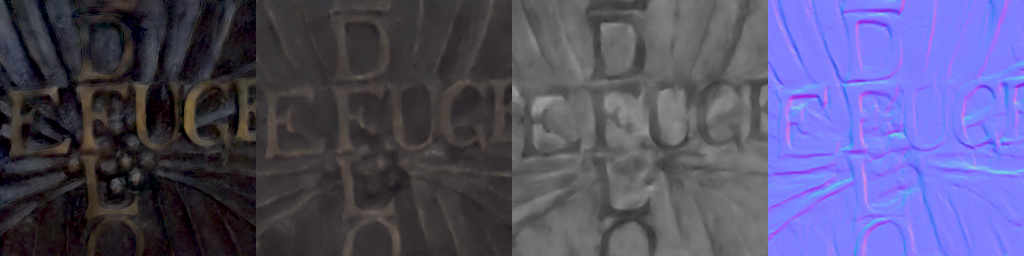

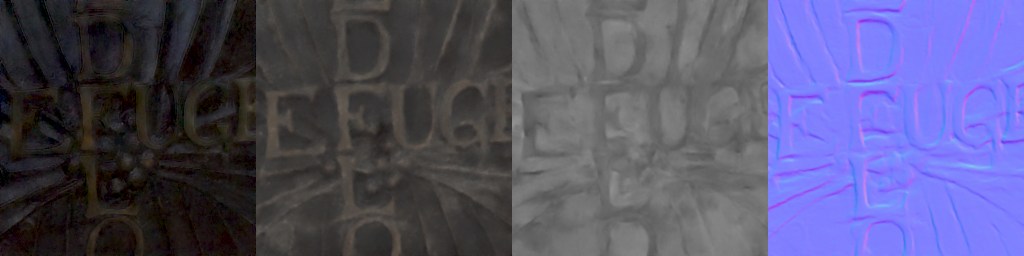

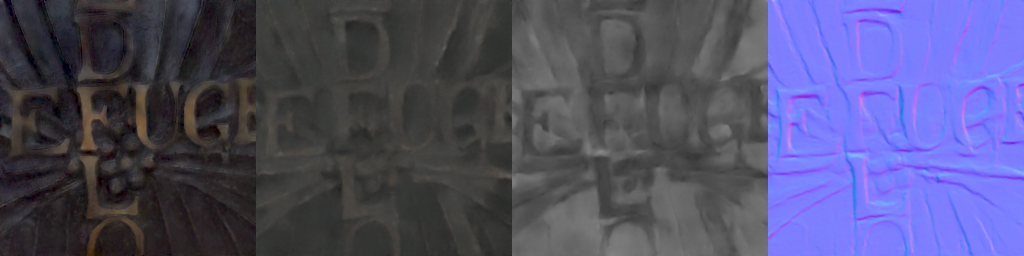

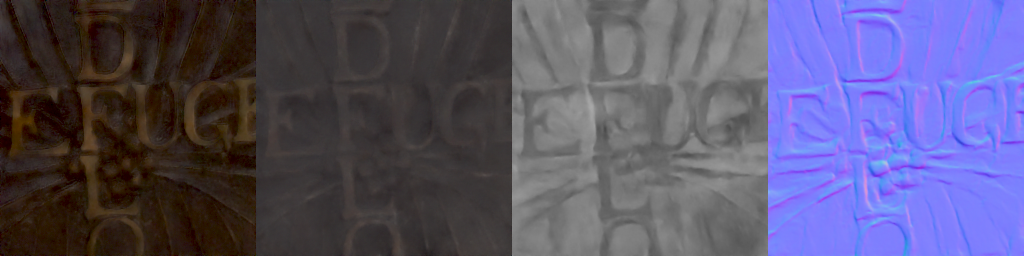

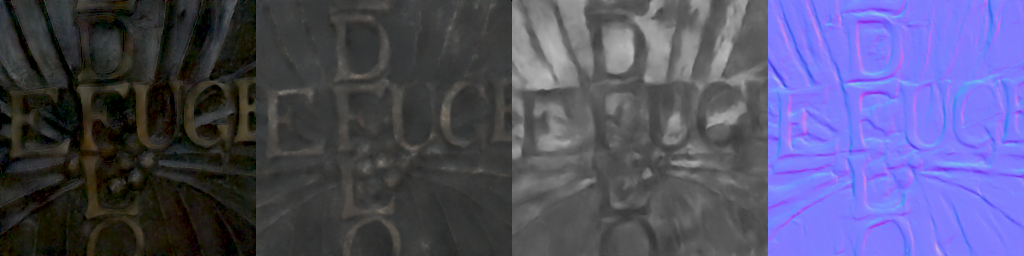

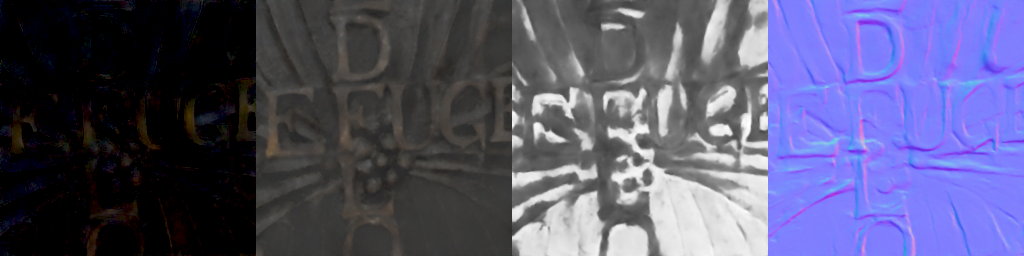

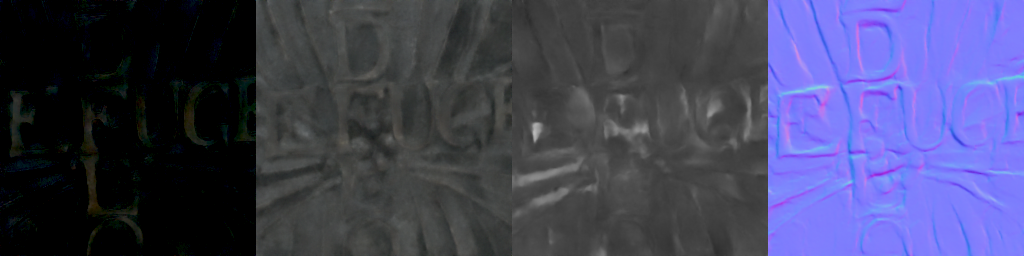

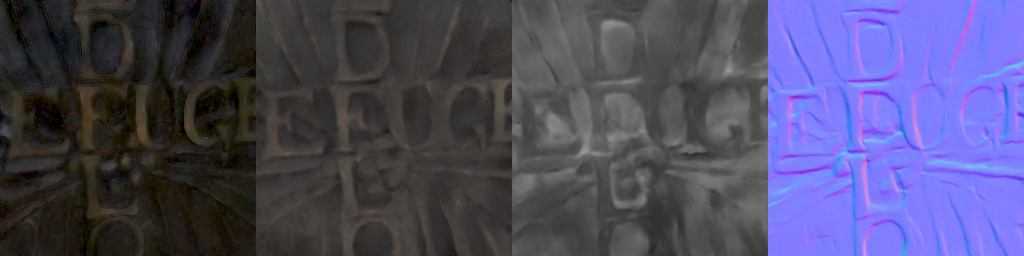

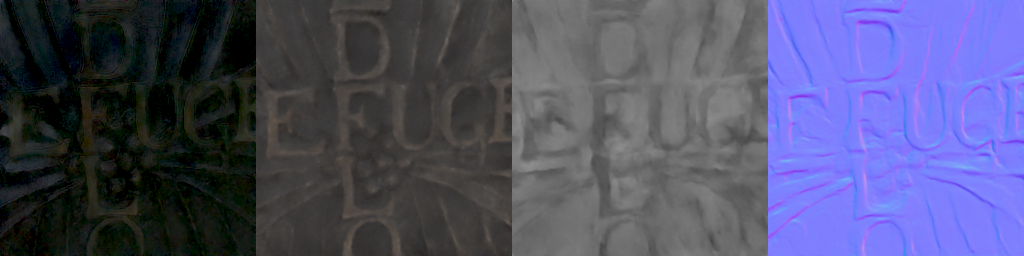

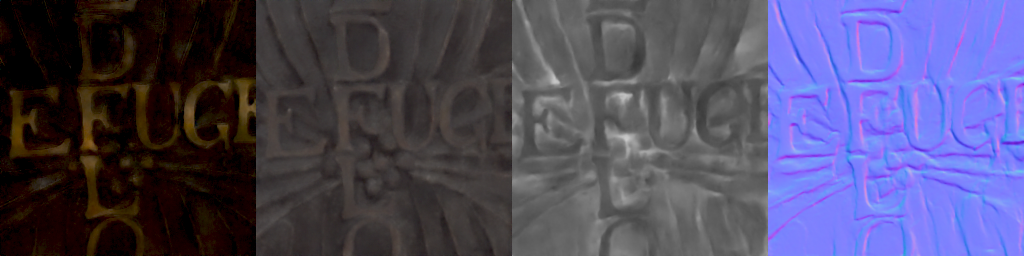

In [10]:
for i in range(replicates):
    show_svbrdf(svbrdf_est[i], horizontal=True, format='png', gamma=2.2)

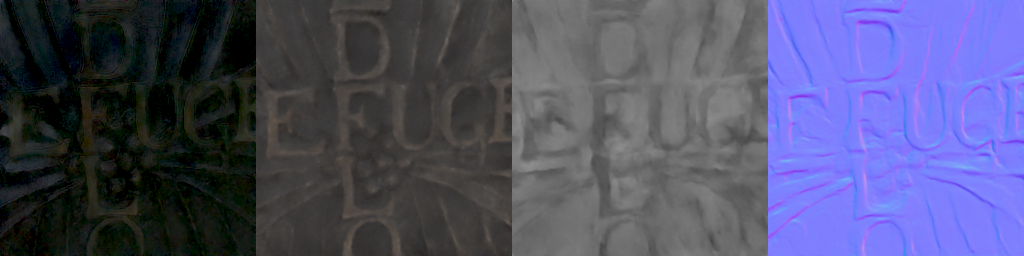

In [11]:
best_replicate = 8
svbrdf_img = display_svbrdf(svbrdf_est[best_replicate], horizontal=True, format='png', gamma=2.2)
Path('./demo/wildflower_sign_svbrdf.png').write_bytes(svbrdf_img.data) # optional: save the svbrdf to disk
svbrdf_img